### 6-2 Applying Sampler to the large - size data

 2018 JASA thesis uses iterative samplers from large multivariate Gaussians to reconstruct bioflim surfaces and to estimate the effect of the treatment on the biofim's volume.
 Here, we will use CSLM images to reconstruct biofilm surfaces using chebyshev-ssor sampler we implemented. 
 

In [12]:
include("pcg_sampler.jl")
include("cheby_mj.jl")

import Base: iterate
using Printf, IterativeSolvers, LinearAlgebra, Random, Distributions, SparseArrays, Arpack
export cg, cg!, CGSampler, PCGSampler, cgSamp!, CGStateVariables

"""
  y ~ N(A^(-1)b , A^(-1))
  x ~ A^(-1)b
"""

mutable struct PCG_cheby_Sampler{precT, matT, solT, vecT, numT <: Real, paramT <: Number}
    Pl::precT
    A::matT
    x::solT
    r::vecT
    c::vecT
    u::vecT
    y::vecT
    reltol::numT
    residual::numT
    ρ::paramT
    ω::numT
    maxiter_pcg::Int
    maxiter_cheby::Int
    mv_products::Int
end

@inline converged(it::PCG_cheby_Sampler) = it.residual ≤ it.reltol

@inline start(it::PCG_cheby_Sampler) = 0

@inline done(it::PCG_cheby_Sampler, iteration::Int) = iteration ≥ it.maxiter_pcg + it.maxiter_cheby || converged(it)

function pcg_cheby!(x, A, y0, b;
    ω::Real = 1,
    tol = sqrt(eps(real(eltype(b)))),
    maxiter_pcg::Int = size(A, 2),
    maxiter_cheby::Int = 10,
    log::Bool = false,
    statevars::CGStateVariables = CGStateVariables(zero(x), similar(x), similar(x)),
    verbose::Bool = false,
    Pl = Identity(),
    kwargs...
)
    pcg_samp = cgSamp!(x, A, y0, b;
        maxiter = maxiter_pcg,
        log= log,
        statevars=statevars,
        verbose=verbose,
        Pl = Pl,
        kwargs...
    )
    Lz = lanczos(pcg_samp.a, pcg_samp.b)
    M = eigs(Lz; nev=1, ritzvec=false, which=:LM)[1][1]
    m = eigs(Lz; nev=1, ritzvec=false, which=:SM)[1][1]
    
    cheby = cheby_ssor_sampler!(pcg_samp.y, A, zeros(A.n), ω, real(M), real(m); 𝛎 = zeros(A.n), maxiter = maxiter_cheby)
    
    return (cheby + pcg_samp.x, pcg_samp.x)
end



pcg_cheby! (generic function with 1 method)

In [13]:

function nz_vals(k, a, b)
    # a, b: complex
    # a: k-vector, b: k-1 vector
    nzs = vcat(a[1], b[1])
    ck = vcat(b[k-1], a[k])
    for i in 2:k-1
        colunit = vcat(b[i-1], a[i], b[i])
        nzs = vcat(nzs, colunit)
    end
    nzs = vcat(nzs, ck)
    nzs
end

function rowidx(k)
    idx = [1; 2]
    unit = [-1; 0; 1]
    for i in 2:k-1
        idx = vcat(idx, unit.+i)
    end
    idx = vcat(idx, [k-1; k])
    idx
end

function colptr(k)
    seq = vcat(2, repeat([3], k-2), 2)
    temp = ones(Int64, k+1)
    for i in 2:k+1
        temp[i] = temp[i-1] + seq[i-1]
    end
    temp
end

function lanczos(a, b)
    k = length(a) -1
    a = a[1:end-1]
    b = b[1:end-1]
    SparseMatrixCSC(k, k, colptr(k), rowidx(k), nz_vals(k, a, b))
end

lanczos (generic function with 1 method)

In [ ]:
using Distributions, Random
include("matrixgen.jl")
n = 512
W = laplacematrix(n)
x = zeros(512^2)
σ2inv, λ = rand(Distributions.Gamma(1, 10000), 2)
A = σ2inv * sparse(I, n^2, n^2) + λ * W

using Preconditioners
L = LowerTriangular(A)
p = CholeskyPreconditioner(L, 2)

using FileIO, Colors, Images
temp = load("frame_1.png")
temp = temp[78:808, 257:1077]
temp = Gray.(imresize(temp, 512, 512))
matrixtemp = Float64.(temp)
scale = minimum(matrixtemp[matrixtemp .> 0])
y = vec(Int64.(matrixtemp ./ scale)) ./ 10;

y0 = 0.5*y + 0.5 * mean(y)*ones(512^2)
b= σ2inv .* y

In [ ]:
pcg_cheby!(x, A, y0 , b;
    ω =1,
    tol = 10^-4,
    maxiter_pcg = 10^3,
    maxiter_cheby = 100,
    Pl = p
)

In [12]:
Random.seed!(100)
samp = cgSamp!(x, A, y0, b;
    tol = 10^-4,
    maxiter= 1000,
    Pl = p)

012345678

PCGSampler{CholeskyPreconditioner{Float64,SparseMatrixCSC{Float64,Int64}},SparseMatrixCSC{Float64,Int64},Array{Float64,1},Array{Float64,1},Float64,Float64}(CholeskyPreconditioner{Float64,SparseMatrixCSC{Float64,Int64}}([29949.981549565287 0.0 … 0.0 0.0; -11247.951232214058 41197.932781779346 … 0.0 0.0; … ; 0.0 0.0 … 41197.932781779346 0.0; 0.0 0.0 … -11247.951232214058 29949.981549565287], 2), 
  [1     ,      1]  =  29950.0
  [2     ,      1]  =  -11248.0
  [513   ,      1]  =  -11248.0
  [1     ,      2]  =  -11248.0
  [2     ,      2]  =  41197.9
  [3     ,      2]  =  -11248.0
  [514   ,      2]  =  -11248.0
  [2     ,      3]  =  -11248.0
  [3     ,      3]  =  41197.9
  [4     ,      3]  =  -11248.0
  [515   ,      3]  =  -11248.0
  [3     ,      4]  =  -11248.0
  ⋮
  [262141, 262141]  =  41197.9
  [262142, 262141]  =  -11248.0
  [261630, 262142]  =  -11248.0
  [262141, 262142]  =  -11248.0
  [262142, 262142]  =  41197.9
  [262143, 262142]  =  -11248.0
  [261631, 262143]  =  -112

In [13]:
Lz = lanczos(samp.a, samp.b)

7×7 SparseMatrixCSC{Complex{Float64},Int64} with 19 stored entries:
  [1 , 1]  =  8.46298e-6+0.0im
  [2 , 1]  =  0.0+7.42422e-7im
  [8 , 2]  =  0.0+7.42422e-7im
  [1 , 2]  =  1.66386e-5+0.0im
  [2 , 2]  =  0.0+4.51954e-6im
  [3 , 3]  =  0.0+4.51954e-6im
  [9 , 3]  =  1.38362e-5+0.0im
  [2 , 3]  =  0.0+4.39257e-6im
  [3 , 4]  =  0.0+4.39257e-6im
  [4 , 4]  =  1.6918e-5+0.0im
  [10, 4]  =  0.0+6.79614e-6im
  [3 , 5]  =  0.0+6.79614e-6im
  [4 , 5]  =  1.84269e-5+0.0im
  [5 , 5]  =  0.0+6.94797e-6im
  [11, 6]  =  0.0+6.94797e-6im
  [4 , 6]  =  1.54155e-5+0.0im
  [5 , 6]  =  0.0+5.99136e-6im
  [6 , 7]  =  0.0+5.99136e-6im
  [12, 7]  =  1.84236e-5+0.0im

In [23]:
eigs(Lz)

(Complex{Float64}[1.0385260667453718e-5 - 9.901230832208791e-6im, 1.0385260667453713e-5 + 9.90123083220879e-6im, 1.021332813946242e-5 - 7.220457831842537e-6im, 1.0213328139462424e-5 + 7.2204578318425316e-6im, 1.0382951613917296e-5 + 1.3820116596225335e-6im, 1.0382951613917293e-5 - 1.3820116596225382e-6im], Complex{Float64}[0.0027365141293407198 + 0.0010061089507672058im -0.002618930024681415 + 0.0012813938999050823im … -0.007115783706187648 + 0.04450166462100174im 0.04497052579217742 + 0.0029469207265335716im; -0.033158531596797484 - 0.04242813351964186im -0.028633410130107367 + 0.04560441377692953im … 0.4174146377347928 + 0.16673185955865596im -0.06984830085053914 - 0.44402219275104743im; … ; -0.2336216900028652 - 0.2545631282870059im -0.20628880941656158 + 0.2771757699232741im … -0.16994831748341155 - 0.011818827479576743im -0.026226224631576263 + 0.1683279550164158im; 0.10654138599197263 + 0.11261364088282871im -0.09443304310942108 + 0.12294429393457705im … -0.5361531199090765 - 0.0

In [ ]:
m = eigs(Lz; nev=1, ritzvec=false, which=:SM)[1][1]

In [7]:
M = eigs(Lz; nev=1, ritzvec=false, which=:LM)[1][1]

ArgumentError: ArgumentError: input matrix A is too small. Use eigen instead.

In [11]:
yresult = reshape(samp.y, 512, 512)

512×512 Array{Float64,2}:
 3.86822  3.86913  3.87047  3.86885  …  4.66854  4.86897  4.97133  5.5754 
 4.31843  4.31825  4.31876  4.31902     5.16893  5.41847  5.36803  6.16786
 4.47027  4.26865  4.06875  3.91883     5.91907  6.36906  6.46898  6.36891
 4.46913  4.2689   4.06879  3.91878     5.96903  6.86907  7.21901  7.06898
 4.46812  4.26881  4.06876  3.91873     7.06901  7.06909  7.56901  7.41884
 4.46866  4.26872  4.06872  3.91871  …  6.26901  6.56909  7.06905  6.91879
 4.46863  4.26867  4.06868  3.91871     6.41896  6.31903  6.51906  6.36897
 4.46848  4.31858  4.11863  3.96869     6.76888  6.31895  6.41896  6.26902
 4.51845  4.4185   4.26856  4.16864     7.06883  6.3689   6.31887  6.31882
 4.51837  4.41845  4.26851  4.16862     6.96882  6.3689   6.31889  6.31871
 4.51839  4.41847  4.26851  4.16861  …  6.76881  6.36889  6.31892  6.31878
 4.51826  4.41851  4.26857  4.16865     6.61878  6.36884  6.31888  6.31886
 4.51827  4.41847  4.26861  4.16871     6.51875  6.36882  6.31882  6.3188 

In [12]:
using Colors, Images
sum(samp.y)

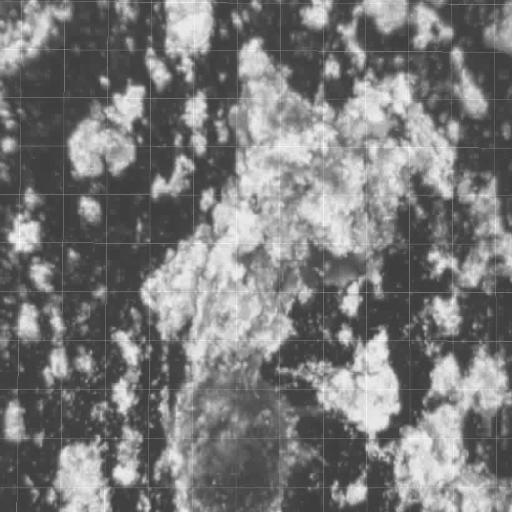

In [14]:
Gray.(yresult ./ maximum(yresult))

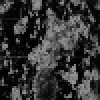

In [8]:
using FileIO, Colors, Images
temp = load("frame_1.png")
temp = temp[78:808, 257:1077]
temp = Gray.(imresize(temp, 50, 50))


In [9]:
matrixtemp = Float64.(temp)
scale = minimum(matrixtemp[matrixtemp .> 0])
y = vec(Int64.(matrixtemp ./ scale)) ./ 10;


In [11]:
include("cheby_mj.jl")
include("matrixgen.jl")
n = 50
W = laplacematrix(n)
x = zeros(n^2)
Random.seed!(1)
σ2inv, λ = rand(Distributions.Gamma(1, 10000), 2)
A = σ2inv * sparse(I, n^2, n^2) + λ * W
ω = 0.9

𝛎 = σ2inv .* y
M, m = eigMm(A , ω)


ARPACKException: ARPACKException: unspecified ARPACK error: 1

In [4]:
cb1 =cheby_ssor_sampler(A, ω, M, m, 𝛎 = 𝛎 , maxiter=100000)


UndefVarError: UndefVarError: M not defined